Here I attempt to build a neural network from scratch without using pytorch or tensorflow

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [49]:
data = pd.read_csv('mnist_train.csv')


In [50]:
data.head() #shows preview


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


but working with numpy arrays works better so lets do that

In [4]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

print(data.shape) #m is the number of digits examples we have in our dataset and n (or rather n-1, snce 1 coulkmn is for label name) is the number of pixels. For ref, look at the table above 

print(data[10039, 600]) #test out which image and pixel value you would like to see - here it is the 10039th image and its 600th pixel

(60000, 785)
99


so our image has a collection 60000 randomized digits(rows) and 785 columns, each entry is a number that represents a pixel (28x28)

In [5]:
#wont train on this data, just for testing purposes
data_dev = data[0:1000].T # lets take the first 1000 rows and transpose it - so now each column represents one image
Y_dev = data_dev[0] #first row
X_dev = data_dev[1:n] #disregards the label row and extracts only the pixel data
X_dev = X_dev / 225.

#the actual training data
data_train = data[1000:m].T #rest of the data from the MNIST dataset from 1000th image
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 225.
_,m_train = X_train.shape

print(data_dev.shape)


(785, 1000)


In [6]:
X_train[: , 0].shape #: means all rows, and 0 means the first column

(784,)

now lets initialize all our parameters

In [7]:
def init_params():
    #weights and biases
    w1 = np.random.rand(10, 784) - 0.5 #2d numpy array with 10 rows and 784 columns with random values bw 0 and 1
    b1 = np.random.rand(10, 1) - 0.5
    w2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return w1, b1, w2, b2


Now let us make the forward propagation function - which is where we take in an image and get a prediction out of it

In [8]:
def relu(z):
    return np.maximum(z,0)
   
def softmax(z):
    return np.exp(z) / sum(np.exp(z))

def for_prop(w1, b1, w2, b2, x):
    a0 = x
    z1 = w1.dot(a0) + b1
    a1 = relu(z1)
    z2 = w2.dot(a1) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2


Now for backward propagation - which is where we start with our prediction and find out how much it deviated from the label. This will allow us to optimize the weights and biases

In [9]:
#used in the function back_prop
def relu_derivative(z):
    return z > 0 #when returning a boolean, false is 0 and true is 1

#used in the function back_prop
def label_encode(y):
    label_y = np.zeros((y.size, y.max() + 1))
    label_y[np.arange(y.size), y] = 1
    #and then lets flip it
    label_y = label_y.T
    return label_y

def back_prop(z1, a1, z2, a2, w1, w2, x, y): #y is the labels - we need to hot encode it seperately above
    label_y = label_encode(y)
    dz2 = a2 - label_y
    dw2 = (1 / m) * dz2.dot(a1.T)
    db2 = (1 / m) * np.sum(dz2)
    
    dz1 = w2.T.dot(dz2) * relu_derivative(z1)
    dw1 = (1 / m) * dz1.dot(x.T)
    db1 = (1 / m) * np.sum(dz1)
    
    return dw1, db1, dw2, db2

def update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    return w1, b1, w2, b2   
      

So now we need some way of actually uses the gradients to update the weights and biases. Without it, the neural networks weights and biases cannot change and the model will not learn. So let us implement gradient descent. the first two functions are going to be something you have to look into

In [10]:
def get_predictions(a2):
    return np.argmax(a2, 0)

def get_accuracy(predictions, y):
    print(predictions, y)
    return np.sum(predictions == y) / y.size


def grad_descent(x, y, iter, alpha):
    w1, b1, w2, b2 = init_params()
    # now we run a loop through the iterations (epoch)
    for i in range(iter):
        #forward propagation
        z1, a1, z2, a2 = for_prop(w1, b1, w2, b2, x)
        #backward propagation
        dw1, db1, dw2, db2 = back_prop(z1, a1, z2, a2, w1, w2, x, y)
        #update the parameters
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
        
        if (i % 10 == 0):
            print("Iteration: ", i)
            print('Accuracy: ', get_accuracy(get_predictions(a2), y))
    
    return w1, b1, w2, b2
        

Now for the excting part - let's run gradient descent with our trainning data!!

In [11]:
w1, b1, w2, b2 = grad_descent(X_train, Y_train, 200, 0.1)

Iteration:  0
[8 8 4 ... 8 0 0] [1 8 8 ... 9 3 4]
Accuracy:  0.06371186440677966
Iteration:  10
[6 8 7 ... 8 3 7] [1 8 8 ... 9 3 4]
Accuracy:  0.15710169491525425
Iteration:  20
[6 8 7 ... 8 3 9] [1 8 8 ... 9 3 4]
Accuracy:  0.2085593220338983
Iteration:  30
[7 3 7 ... 9 3 9] [1 8 8 ... 9 3 4]
Accuracy:  0.24864406779661016
Iteration:  40
[8 3 9 ... 9 3 9] [1 8 8 ... 9 3 4]
Accuracy:  0.28420338983050847
Iteration:  50
[8 3 9 ... 9 3 9] [1 8 8 ... 9 3 4]
Accuracy:  0.32093220338983053
Iteration:  60
[8 3 9 ... 9 3 9] [1 8 8 ... 9 3 4]
Accuracy:  0.36927118644067797
Iteration:  70
[8 3 9 ... 9 3 9] [1 8 8 ... 9 3 4]
Accuracy:  0.4322372881355932
Iteration:  80
[8 3 9 ... 7 3 9] [1 8 8 ... 9 3 4]
Accuracy:  0.48901694915254235
Iteration:  90
[1 3 9 ... 7 3 4] [1 8 8 ... 9 3 4]
Accuracy:  0.5346271186440678
Iteration:  100
[1 3 9 ... 9 3 4] [1 8 8 ... 9 3 4]
Accuracy:  0.5695593220338983
Iteration:  110
[1 3 8 ... 9 3 4] [1 8 8 ... 9 3 4]
Accuracy:  0.5987966101694915
Iteration:  120
[1 3

In [22]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = for_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_dev[:, index, None]
    prediction = make_predictions(X_dev[:, index, None], W1, b1, W2, b2)
    label = Y_dev[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


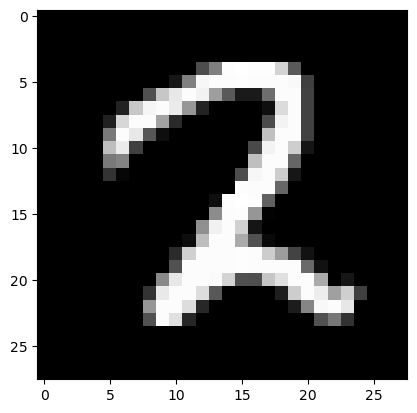

In [47]:
test_prediction(27, w1, b1, w2, b2)